In [251]:
def get_distances(traj):
    """Create a distance matrix"""
    import mdtraj as md
    from mdtraj.geometry.alignment import compute_average_structure
    import numpy as np
    traj_aligned = traj.superpose(traj[0], parallel=True)

    # matrix initialization
    distances = np.empty((traj.n_frames, traj.n_frames))
    # Pairwise RMSD calculation (matrix n²)
    for i in range(traj.n_frames):
        distances[i]=md.rmsd(traj_aligned,traj_aligned, frame=i)
    return distances

In [252]:
def TSNE_cluster(distances, min_cluster_size):
    """Create a TSNE cluster"""
    from sklearn.manifold import TSNE
    import hdbscan
    import matplotlib.pyplot as plt

    model = TSNE(n_components=2,verbose=2,perplexity=10,learning_rate=100)
    data_tsne = model.fit_transform(distances)
    #plt.scatter(data_tsne.T[0],data_tsne.T[1],cmap="gnuplot")
    cluster = hdbscan.HDBSCAN(min_cluster_size)
    cluster.fit(data_tsne)
    plt.scatter(data_tsne.T[0],data_tsne.T[1],cmap="gnuplot",c=cluster.labels_)
    print(len(set(cluster.labels_)), set(cluster.labels_))
    return  data_tsne, cluster

In [253]:
# cargar los archivos de trajectoria 

import mdtraj as md

topology_file = '/Users/juanb/tesis/pep_cicl/MD/maestro/prod_pc_1t7d_2/top.pdb'  
trajectory_file = '/Users/juanb/tesis/pep_cicl/MD/maestro/prod_pc_1t7d_2/prod_pc_1t7d_2_trj/clickme.dtr'
traj = md.load(trajectory_file, top=topology_file)

In [254]:
residues = traj.topology.select('(chainid 0 and resid 0 to 15) and not resname ACE and not resname NME and not resname T4P and not resname CL and not resname NA')
traj_protein_only = traj.atom_slice(residues)
print (traj_protein_only)

<mdtraj.Trajectory with 1002 frames, 130 atoms, 16 residues, and unitcells>


In [265]:
for chain in traj_protein_only.topology.chains:
    print(f"Chain {chain.index}:")
    for residue in chain.residues:
        print(f"{residue.index} {residue.name}")

Chain 0:
0 ASP
1 GLN
2 TRP
3 MLE
4 GLN
5 VAL
6 ASP
7 ORN
8 GLU
9 VAL
10 THR
11 GLY
12 ILE
13 ILE
14 THR
15 ORN


In [256]:
traj = traj_protein_only.superpose(traj_protein_only[0], parallel=True)
print("Trajectory superpose!")
distances_traj = get_distances(traj)
print("Distances matrix ready!")

Trajectory superpose!
Distances matrix ready!


RMSD done!
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1002 samples in 0.001s...
[t-SNE] Computed neighbors for 1002 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1002
[t-SNE] Computed conditional probabilities for sample 1002 / 1002
[t-SNE] Mean sigma: 0.206712
[t-SNE] Computed conditional probabilities in 0.010s
[t-SNE] Iteration 50: error = 73.5204544, gradient norm = 0.0720583 (50 iterations in 0.217s)
[t-SNE] Iteration 100: error = 67.1528778, gradient norm = 0.0287992 (50 iterations in 0.147s)
[t-SNE] Iteration 150: error = 65.7478638, gradient norm = 0.0167101 (50 iterations in 0.110s)
[t-SNE] Iteration 200: error = 65.1225204, gradient norm = 0.0120045 (50 iterations in 0.104s)
[t-SNE] Iteration 250: error = 64.7065125, gradient norm = 0.0076346 (50 iterations in 0.096s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.706512
[t-SNE] Iteration 300: error = 1.1352305, gradient norm = 0.0135895 (50 iterations

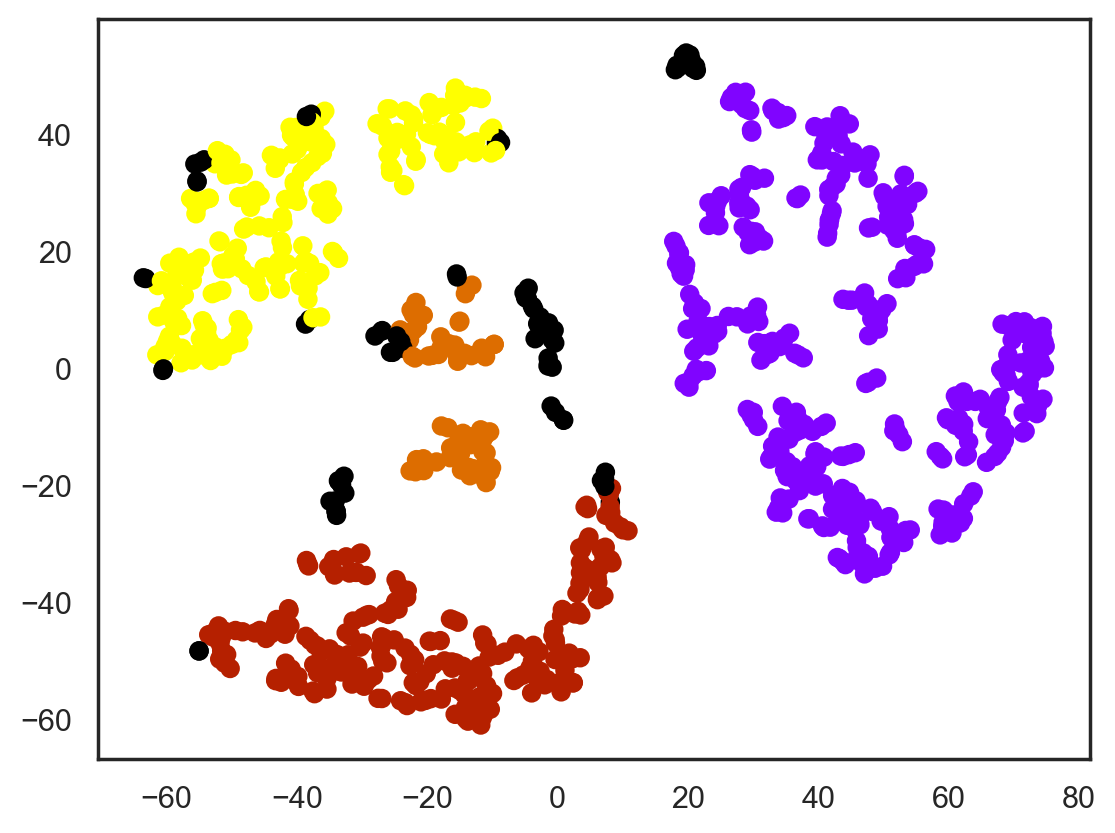

In [257]:
rmsds_traj = md.rmsd(traj_protein_only, traj_protein_only, 0)
print("RMSD done!")
data_tsne_traj,cluster_traj   = TSNE_cluster(distances_traj, 37) #este ultimo valor se puede ajustar, este indica el valor minimo de estructuras necesarias para crear un cluster 
print("Clustering ready!")


In [261]:
# creacion de un data frame 

import pandas as pd
import numpy as np

reference = traj[0]
rmsd = md.rmsd(traj, reference)

start_frame = 0
rmsd_ = rmsd[start_frame:]

data_rmsds_Gn = pd.DataFrame([rmsd_], index=["RMSD"])
data_rmsds_Gn = data_rmsds_Gn.T
data_rmsds_Gn["time"] = np.arange(len(data_rmsds_Gn ["RMSD"]))

#data_rmsds_Gn['y_cluster'] = np.full((1, 1002), -0.1)[0]
#data_rmsds_Gn['x_cluster'] = cluster_traj.labels_
#data_rmsds_Gn

/var/folders/km/slw2x0qd31s3v6nydw0rq6w00000gp/T/ipykernel_1625/1036582209.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(x="time", y="RMSD", data=data_rmsds_Gn, palette="tab10", linewidth=1.5, dashes=False)


Text(0, 0.5, 'RMSD ($\\AA$)')

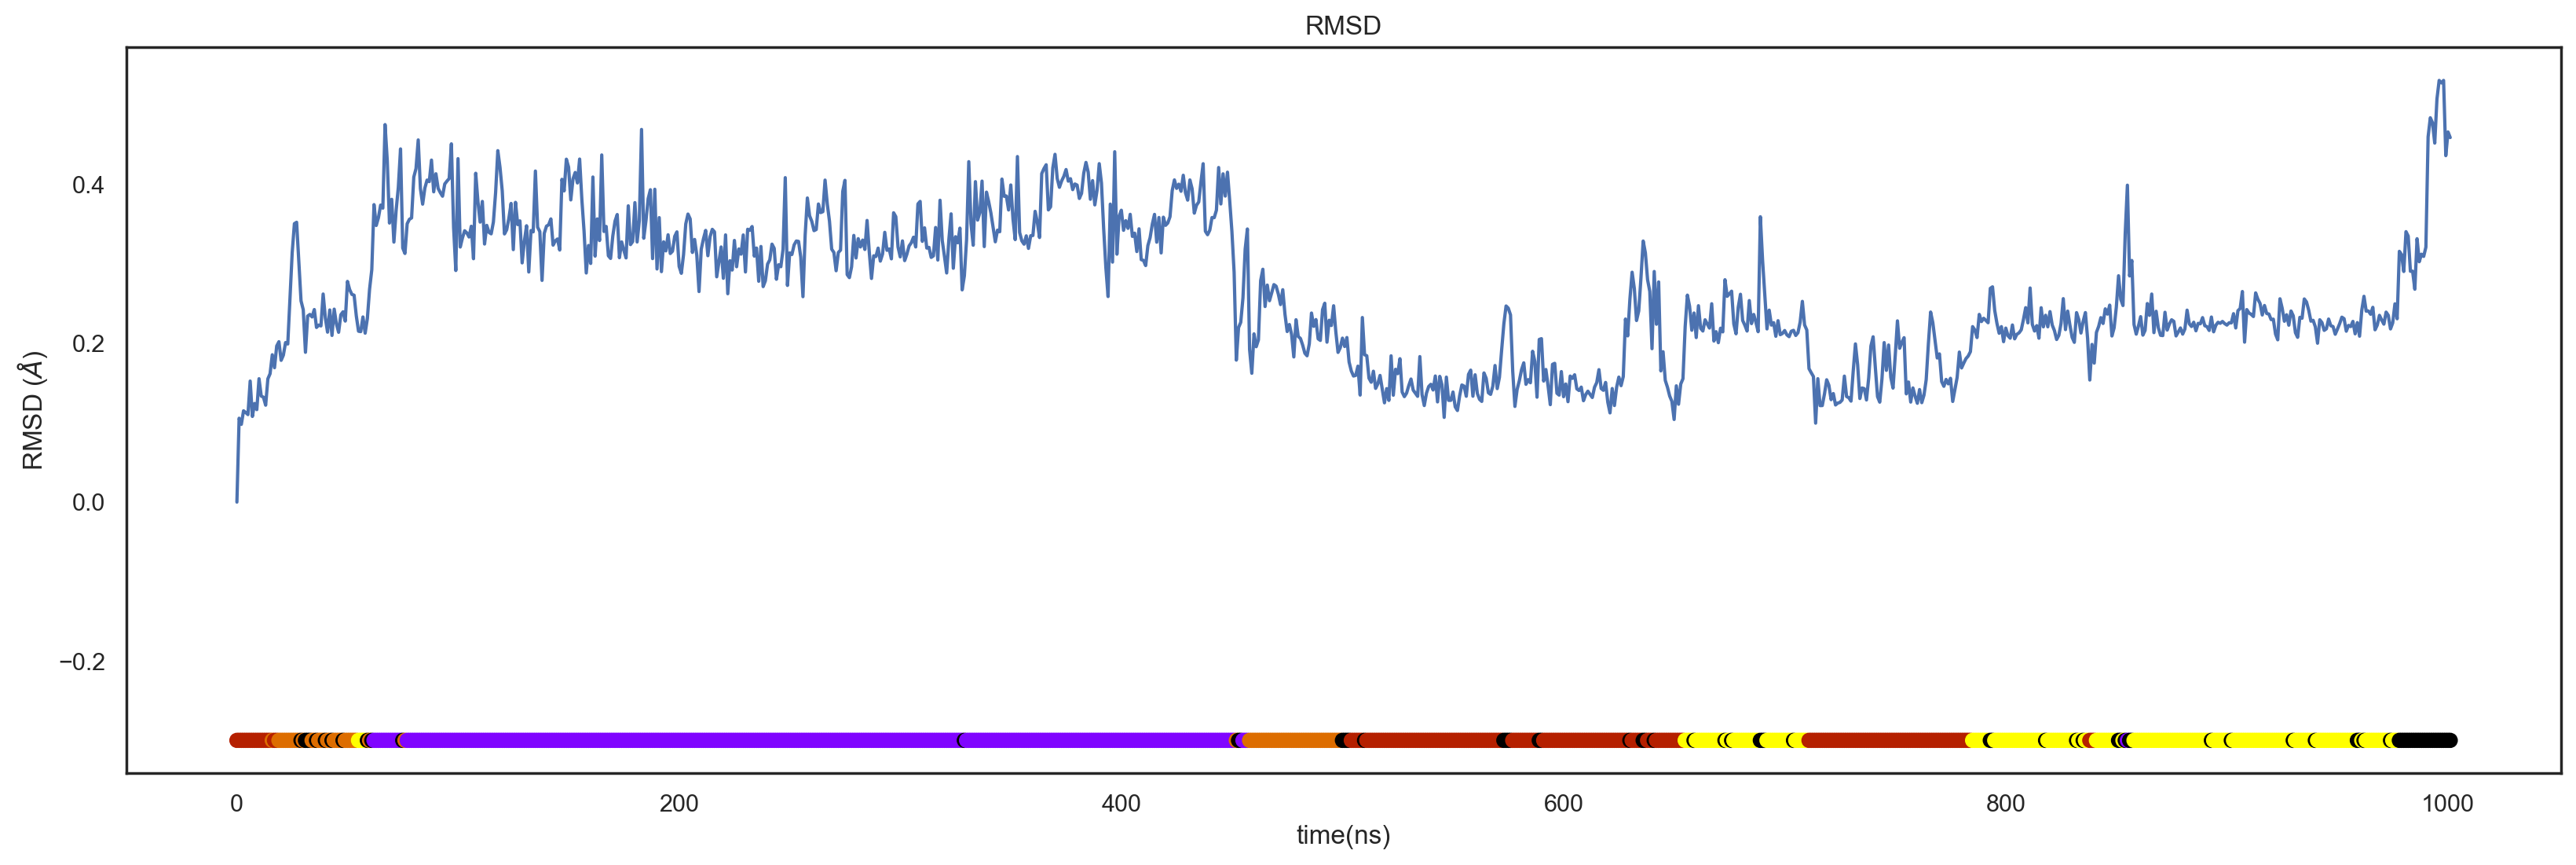

In [262]:
#RMSD

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(1, figsize=(20,6))

sns.set(style="whitegrid")
sns.set(style="white")
plot = sns.lineplot(x="time", y="RMSD", data=data_rmsds_Gn, palette="tab10", linewidth=1.5, dashes=False)

#plt.plot([2585/50], [-0.25], '-gD')
plt.scatter(data_rmsds_Gn['time'], np.full((1, 1002), -0.3),cmap="gnuplot",c=cluster_traj.labels_[:]) # en "np.full((1, #) en # se debe agregar el numero de frames de la dinamica"


plt.title('RMSD')
#plt.legend(('RMSD pc_1t7d'), loc='upper left')
plt.xlabel("time(ns)")
plt.ylabel(r"RMSD ($\AA$)")


/var/folders/km/slw2x0qd31s3v6nydw0rq6w00000gp/T/ipykernel_1625/2503226000.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Groups", y="Frames", data=data8[1:], palette="gnuplot")


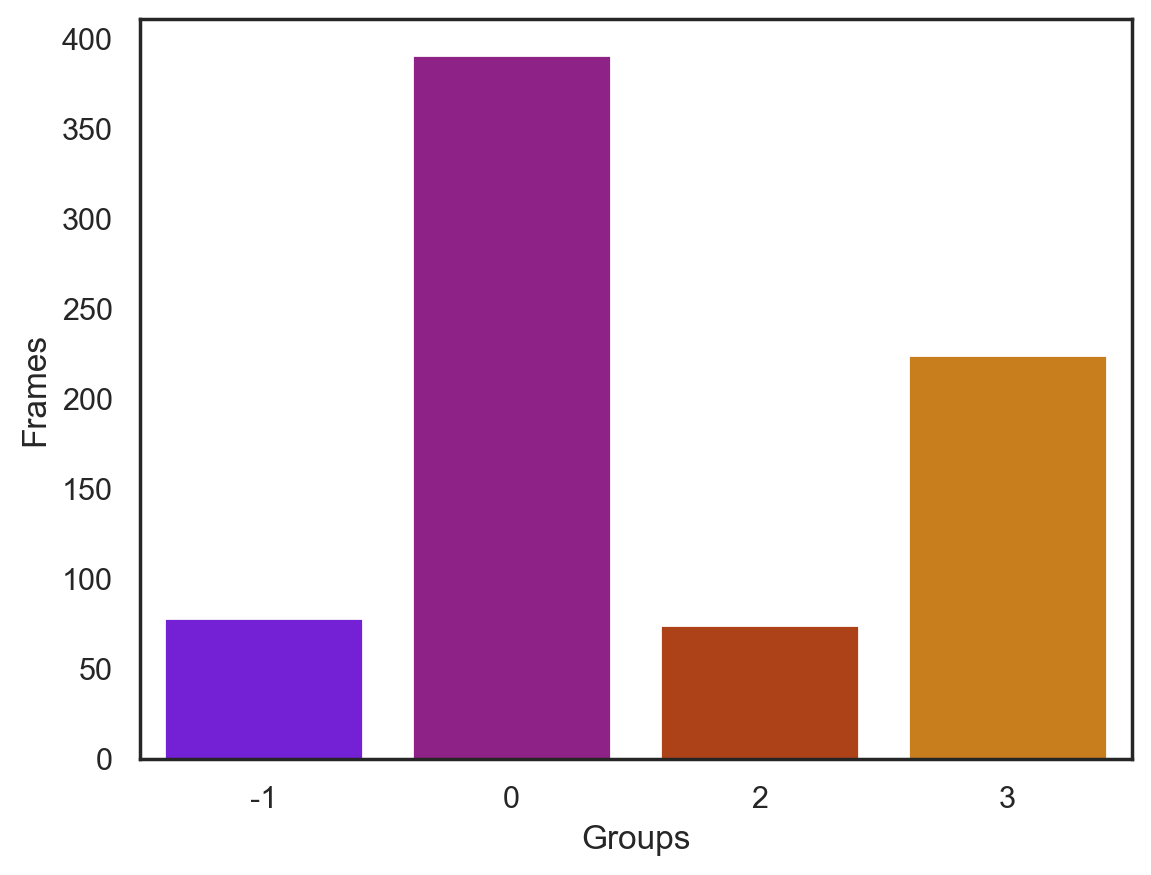

In [264]:
from collections import Counter
import pandas as pd
import seaborn as sns
labels, values = zip(*Counter(cluster_traj.labels_).items())
data8 = pd.DataFrame([labels,values], ["Groups","Frames"])
data8 = data8.T
ax = sns.barplot(x="Groups", y="Frames", data=data8[1:], palette="gnuplot")

In [245]:
def get_centroid(traj, cluster, name, select=-1):
    """Centroid"""
    traj_aligned = traj.superpose(traj[0], parallel=True)
    
    from collections import defaultdict
    tally = defaultdict(list)
    
    for i,item in enumerate(cluster.labels_):
        tally[item].append(i)
    labels = list(set(cluster.labels_))
    frames = []
    
    if select < 0:
        labels = labels[:-1]
    if select > 0:
        labels = [labels[select]]
        
    for lab in labels:
        traj_cluster = traj_aligned.slice(tally[lab])
        atom_indices = [a.index for a in traj_cluster.topology.atoms if a.element.symbol != 'H']
        distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
        for i in range(traj_cluster.n_frames):
            distances[i] = md.rmsd(traj_cluster, traj_cluster, i, atom_indices=atom_indices)
        beta = 1
        index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
        print(index)
        frames.append((traj_cluster.n_frames, index))
        centroid = traj_cluster[index]
        centroid.save_pdb("%s_c%s_%03d.pdb"%(name, lab, index))
        
        frames = []
        for i,value in enumerate(cluster_traj.labels_):
            if value == lab:
                frames.append(i)
        global_index = frames[index]

    return index, global_index, centroide

In [246]:
# en esta linea se debe agregar la posición del cluster mas grande 

index, global_index, centroide = get_centroid(traj, cluster_traj, "traj", 1)

204


In [247]:
# en esta parte del cogido se dara un frame represetativo del centroide 
frames = []
for i,value in enumerate(cluster_traj.labels_):
    if value == 1:
        frames.append(i)
len(frames)
frames[204]

757

In [195]:
frame_index = 698 # en esta parte se debe coloar el valor del frame más representativo del centroide
frame = traj[frame_index]

# Guardar el frame seleccionado como archivo PDB
output_pdb_file = f'estructura_frame_{frame_index}.pdb'
frame.save_pdb(output_pdb_file)

print(f"Estructura PDB del frame {frame_index} guardada en {output_pdb_file}")

Estructura PDB del frame 698 guardada en estructura_frame_698.pdb


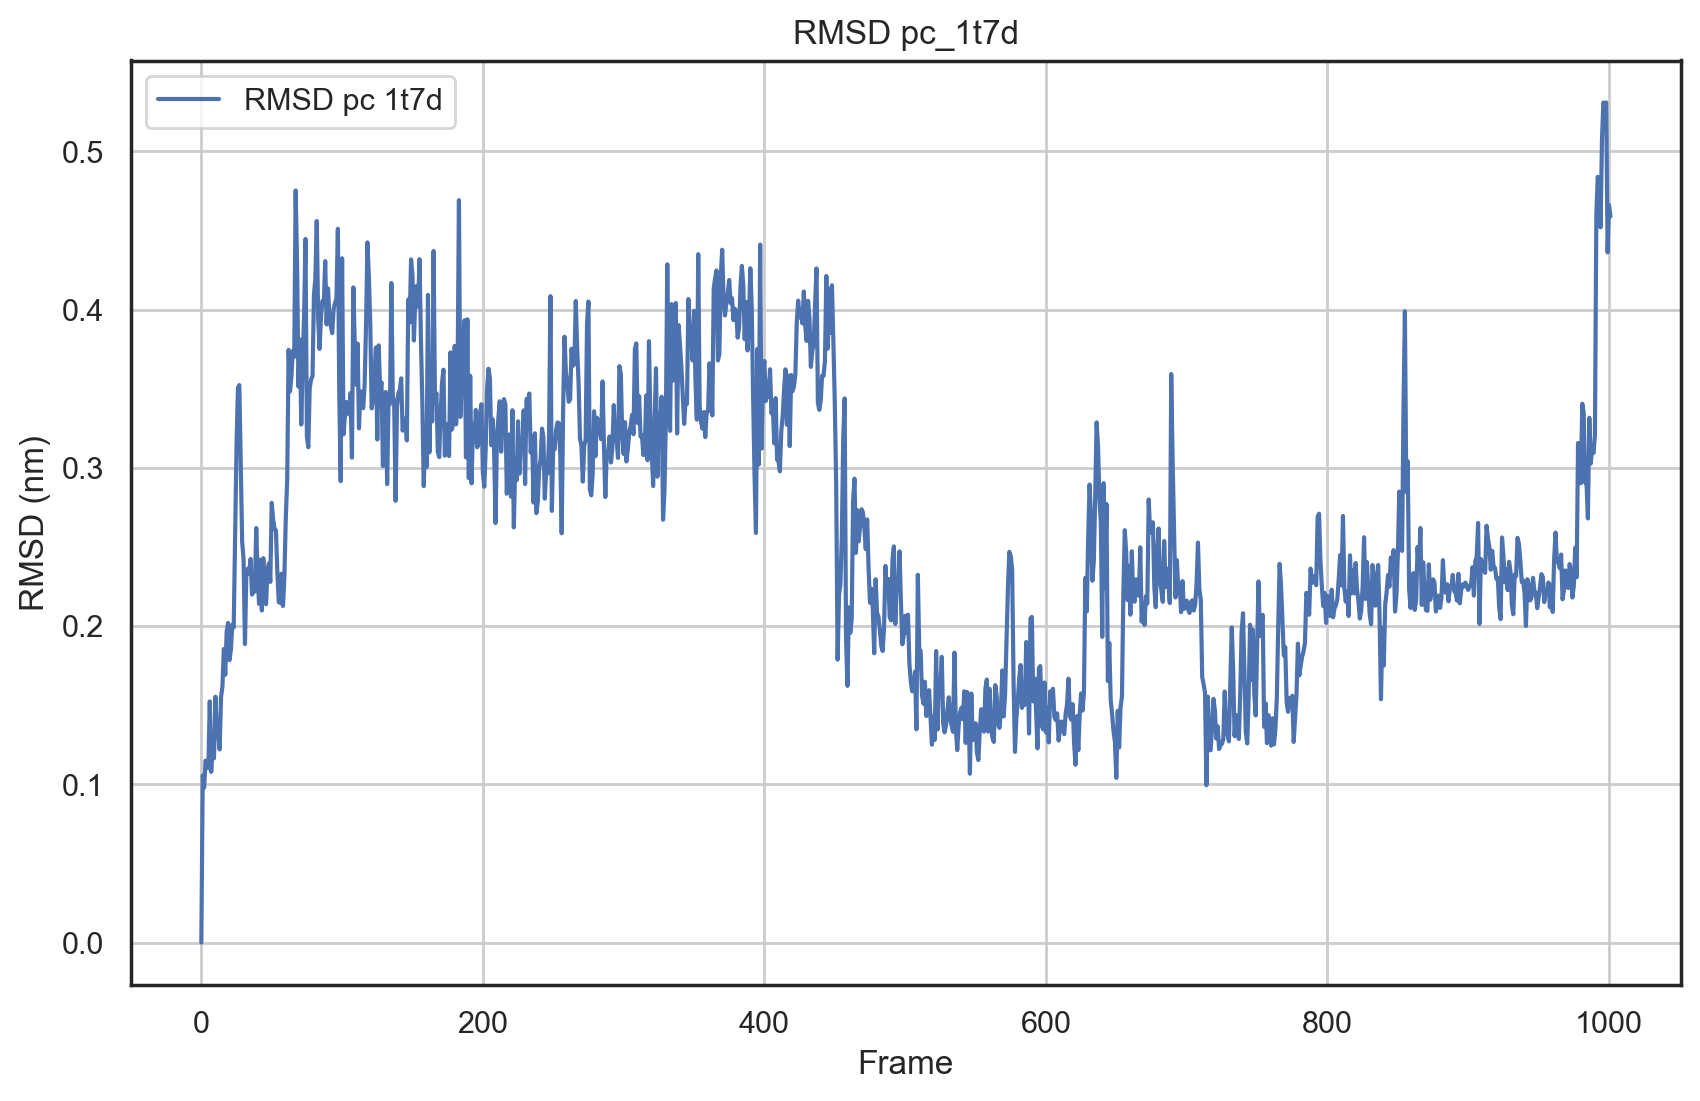

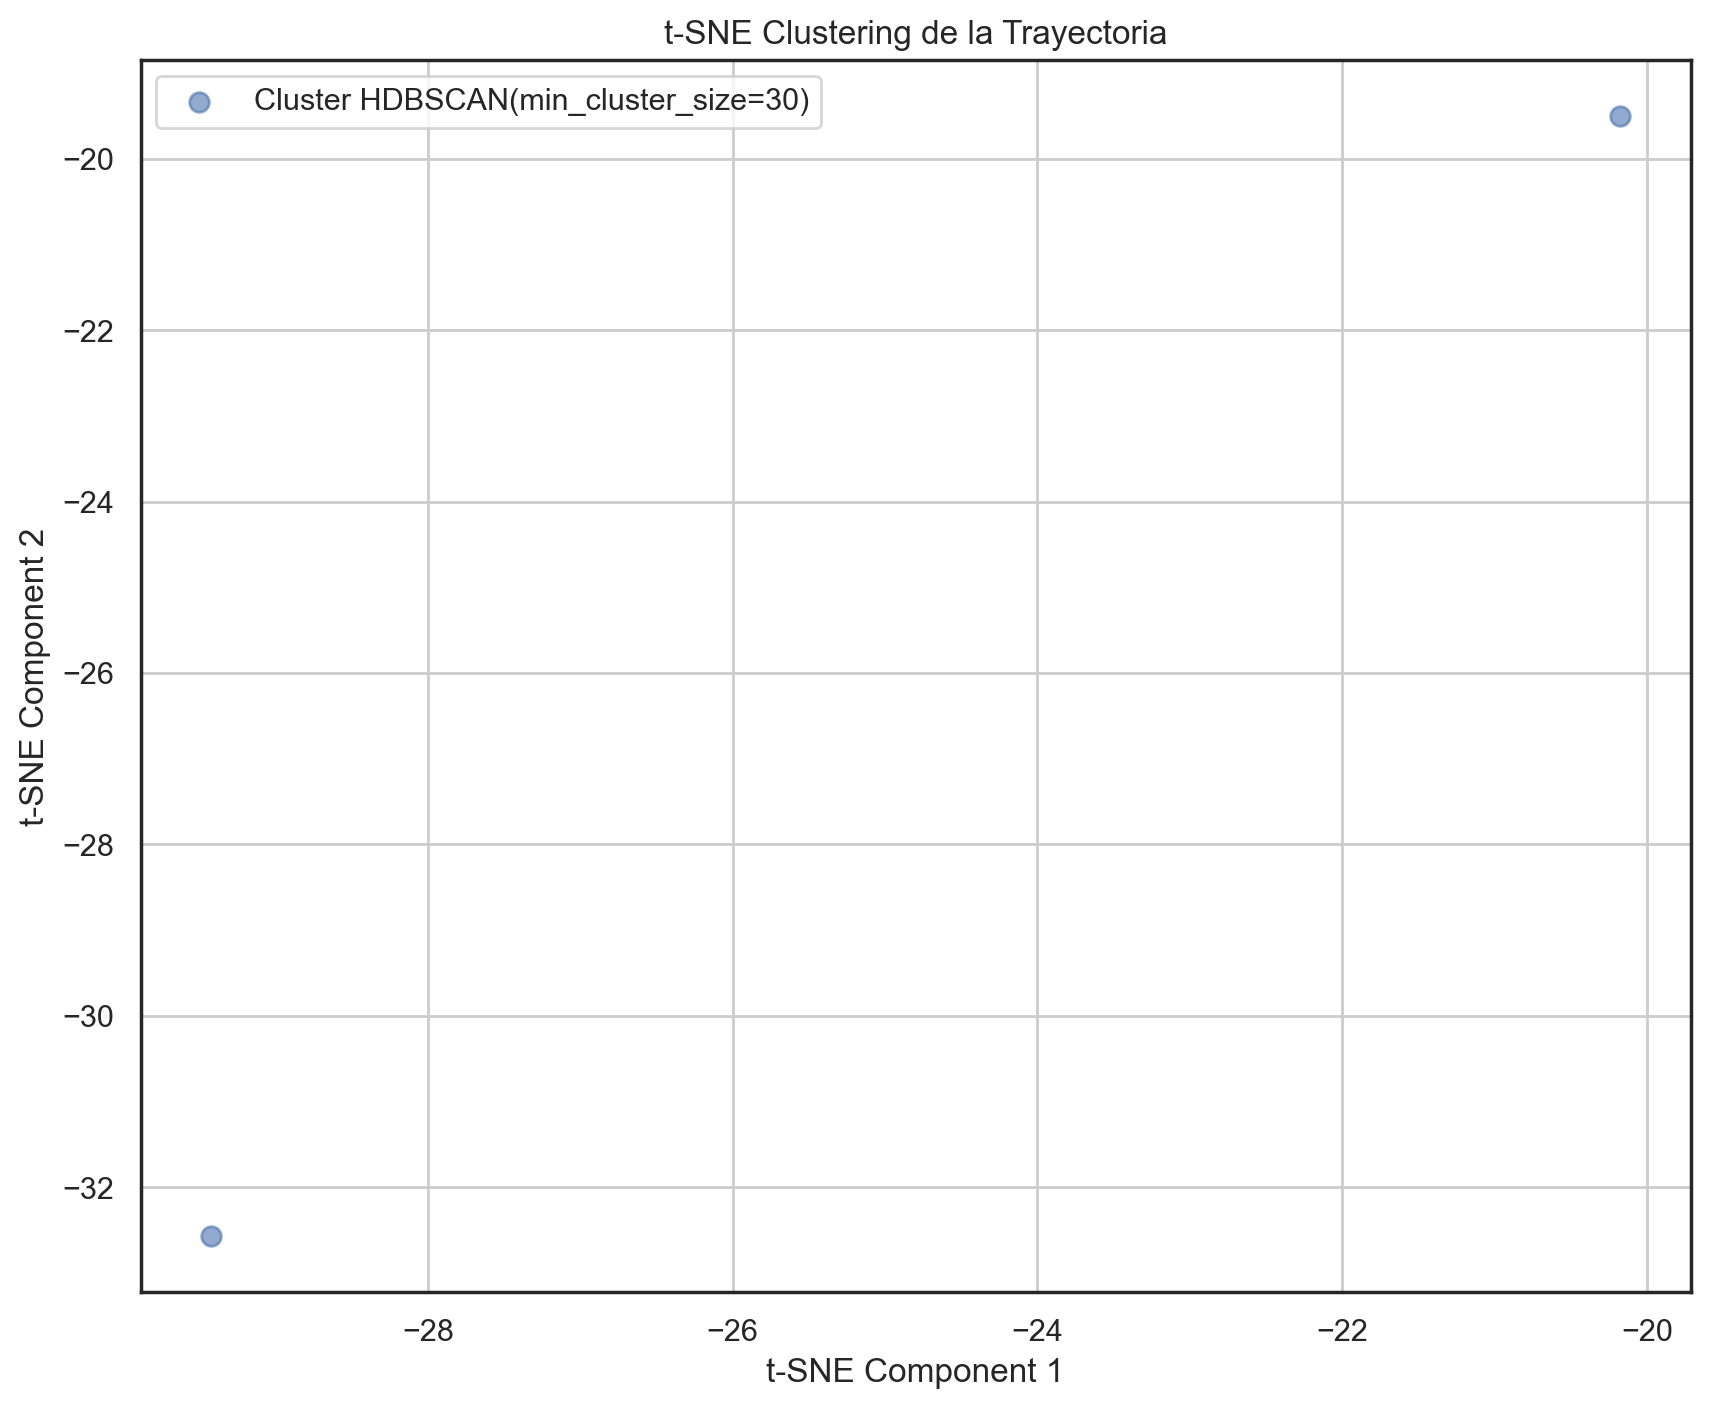